#### Clustering Anomaly Detection Exercises


In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math

from sklearn import metrics
from random import randint
from matplotlib import style

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

1. Use DBSCAN to detect anomalies in curriculumn access. 

In [113]:
df = pd.read_csv('curriculum_logs.csv')

df.head(3)

,Unnamed: 0,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
1,1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2,2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0


In [114]:
# concatenate and change date type columns to the respective type 
df['date_time'] = df.date + ' ' + df.time
df.date_time = pd.to_datetime(df.date_time, format = '%Y-%m-%d %H:%M:%S')
df.date = pd.to_datetime(df.date)
df.time = pd.to_datetime(df.time).dt.time
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)
df.created_at = pd.to_datetime(df.created_at)
df.deleted_at = pd.to_datetime(df.deleted_at)

# missing entirety of columns
df.drop(['Unnamed: 0', 'id', 'slack','deleted_at'], inplace = True, axis = 1)

# let's clean up the dataset
df.dropna(inplace = True)

# set the index
df = df.set_index(df.date)

# let's rename some columns
df.rename(columns = {'path':'endpoint', 'ip':'source_ip'}, inplace = True)

# add program name to dataframe
df['program_name'] = df.program_id.map({1.0: 'Full-Stack PHP',
                                        2.0: 'Full-Stack Java',
                                        3.0: 'Data Science',
                                        4.0: 'Front-End'})

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 847329 entries, 2018-01-26 to 2021-04-21
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          847329 non-null  datetime64[ns]
 1   time          847329 non-null  object        
 2   endpoint      847329 non-null  object        
 3   user_id       847329 non-null  int64         
 4   cohort_id     847329 non-null  float64       
 5   source_ip     847329 non-null  object        
 6   name          847329 non-null  object        
 7   start_date    847329 non-null  datetime64[ns]
 8   end_date      847329 non-null  datetime64[ns]
 9   created_at    847329 non-null  datetime64[ns]
 10  updated_at    847329 non-null  object        
 11  program_id    847329 non-null  float64       
 12  date_time     847329 non-null  datetime64[ns]
 13  program_name  847329 non-null  object        
dtypes: datetime64[ns](5), float64(2), int64(1), object(6

In [115]:
df.head(3)

,date,time,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,created_at,updated_at,program_id,date_time,program_name
date,,,,,,,,,,,,,,
2018-01-26,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:55:03,Full-Stack PHP
2018-01-26,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:56:02,Full-Stack PHP
2018-01-26,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:56:05,Full-Stack PHP


In [142]:
page_views = df.groupby(['user_id'])['name'].agg(['count', 'nunique'])
page_views

,count,nunique
user_id,,
1,7404,2
2,1541,1
3,1562,1
4,692,1
5,1701,1
...,...,...
977,86,1
978,55,1
979,127,1


In [143]:
# Make the scaler
scaler = MinMaxScaler().fit(page_views)

# Use the scaler
page_views_scaled = scaler.transform(page_views)
page_views_scaled.shape

(911, 2)

In [144]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 4)

# Fit the object
dbsc.fit(page_views_scaled)

DBSCAN(eps=0.1, min_samples=4)

In [145]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(page_views.columns)
scaled_columns = ['scaled_' + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(page_views_scaled, columns = scaled_columns, index = page_views.index)

# Merge the scaled and non-scaled values into one dataframe
page_views = page_views.merge(scaled_df, left_index=True, right_index=True)
page_views

,count,nunique,scaled_count,scaled_nunique
user_id,,,,
1,7404,2,0.413298,0.5
2,1541,1,0.085976,0.0
3,1562,1,0.087148,0.0
4,692,1,0.038577,0.0
5,1701,1,0.094908,0.0
...,...,...,...,...
977,86,1,0.004745,0.0
978,55,1,0.003015,0.0
979,127,1,0.007034,0.0


In [146]:
labels = dbsc.labels_

In [147]:
page_views['labels'] = labels

page_views.labels.value_counts()

 1    872
 0     35
-1      4
Name: labels, dtype: int64

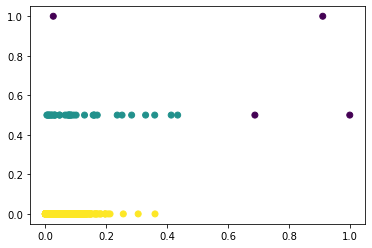

In [148]:
plt.scatter(page_views['scaled_count'], page_views['scaled_nunique'], c=page_views.labels)
plt.show()